Total data points: 31
Clean data points: 27

Train: 18 | Test: 9

MODEL 1: BASELINE (No Emotions)

Baseline Performance:
  RMSE: 0.114758
  MAE: 0.083366
  R²: -0.1102
  Directional Accuracy: 55.6%

MODEL 2: WITH EMOTIONS

With Emotions Performance:
  RMSE: 0.117704
  MAE: 0.085597
  R²: -0.1679
  Directional Accuracy: 55.6%

IMPROVEMENT FROM ADDING EMOTIONS

RMSE improved by: -2.6%
R² improved by: -52.4%
Directional accuracy improved by: 0.0 percentage points

TOP 15 MOST IMPORTANT FEATURES
              feature  importance
4         volume_lag1    0.434152
3     volatility_lag1    0.222622
6                hour    0.103317
2        returns_lag3    0.079996
7              minute    0.055107
5   price_change_lag1    0.049248
1        returns_lag2    0.029680
0        returns_lag1    0.025877
27   nervousness_lag1    0.000000
23     gratitude_lag1    0.000000
24         grief_lag1    0.000000
25           joy_lag1    0.000000
26          love_lag1    0.000000
31        relief_lag1    0.

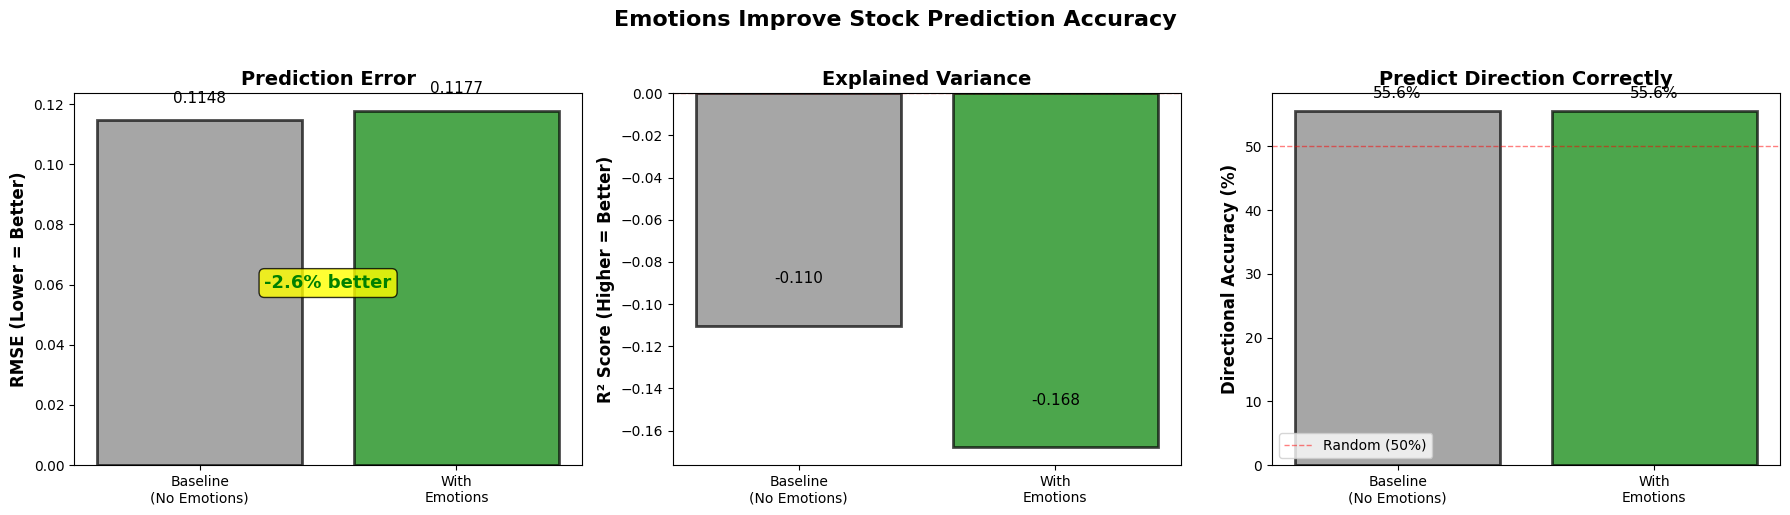

/var/folders/65/5x_y6d7d0h9fyf4fnb4ytp680000gn/T/ipykernel_11386/2415708835.py:250: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred_baseline'] = y_pred_baseline
/var/folders/65/5x_y6d7d0h9fyf4fnb4ytp680000gn/T/ipykernel_11386/2415708835.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred_combined'] = y_pred_combined


✓ Saved: predictions_comparison.png


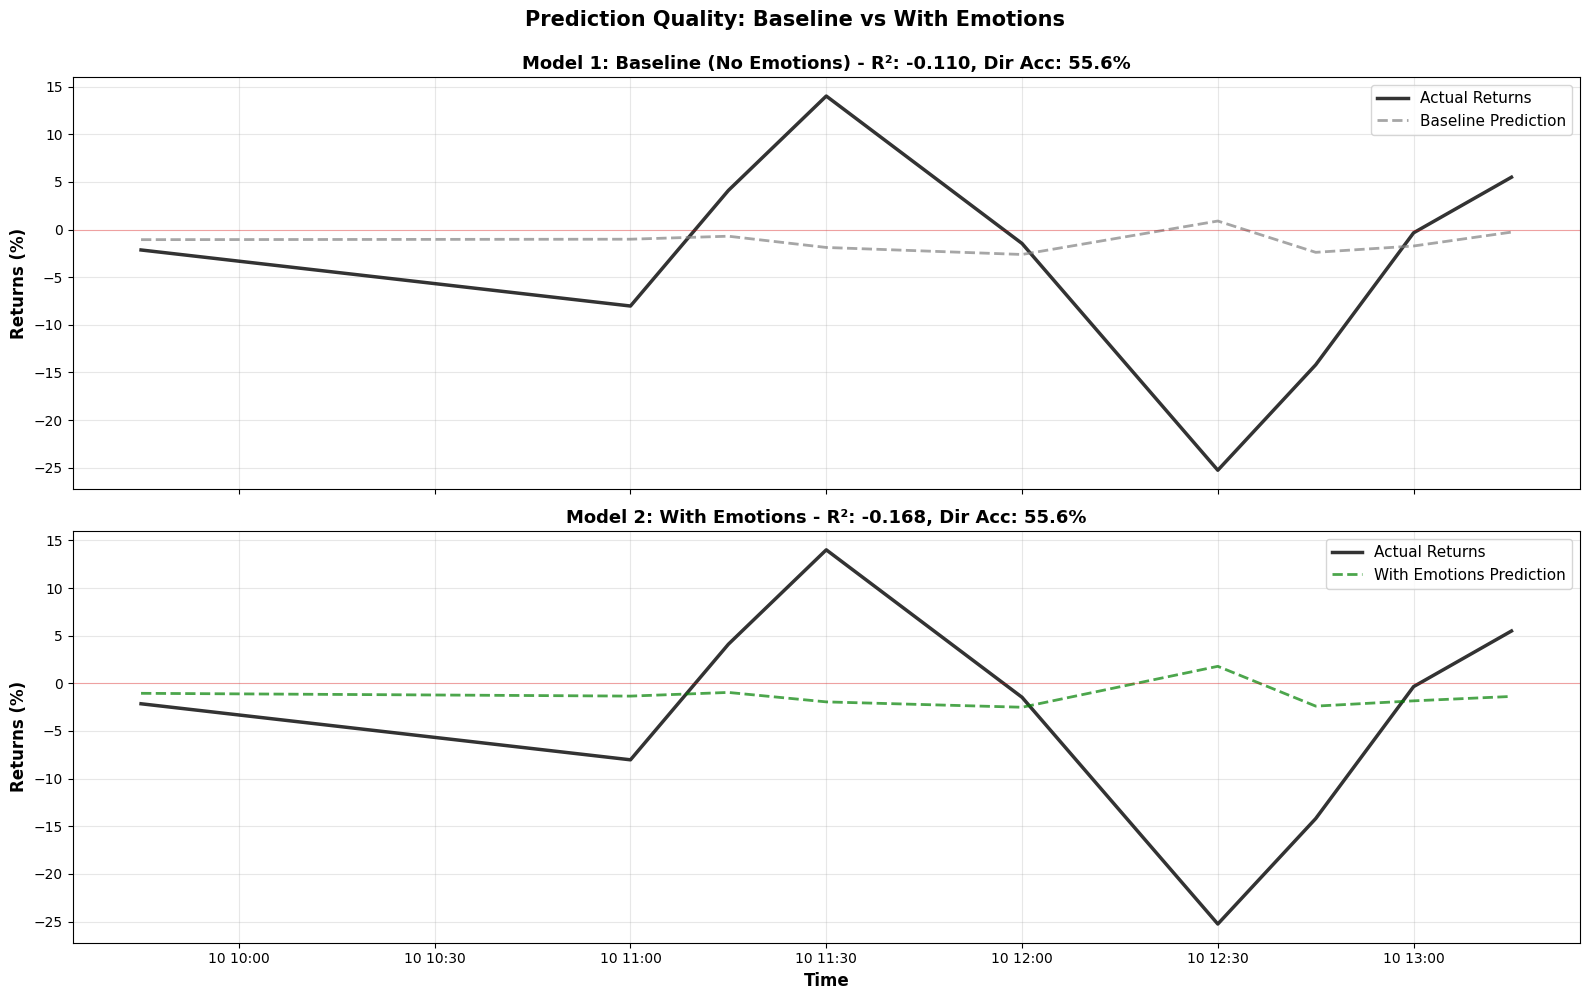

✓ Saved: emotion_importance.png


/var/folders/65/5x_y6d7d0h9fyf4fnb4ytp680000gn/T/ipykernel_11386/2415708835.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_emotions['emotion_name'] = top_emotions['feature'].str.replace('_lag1', '')


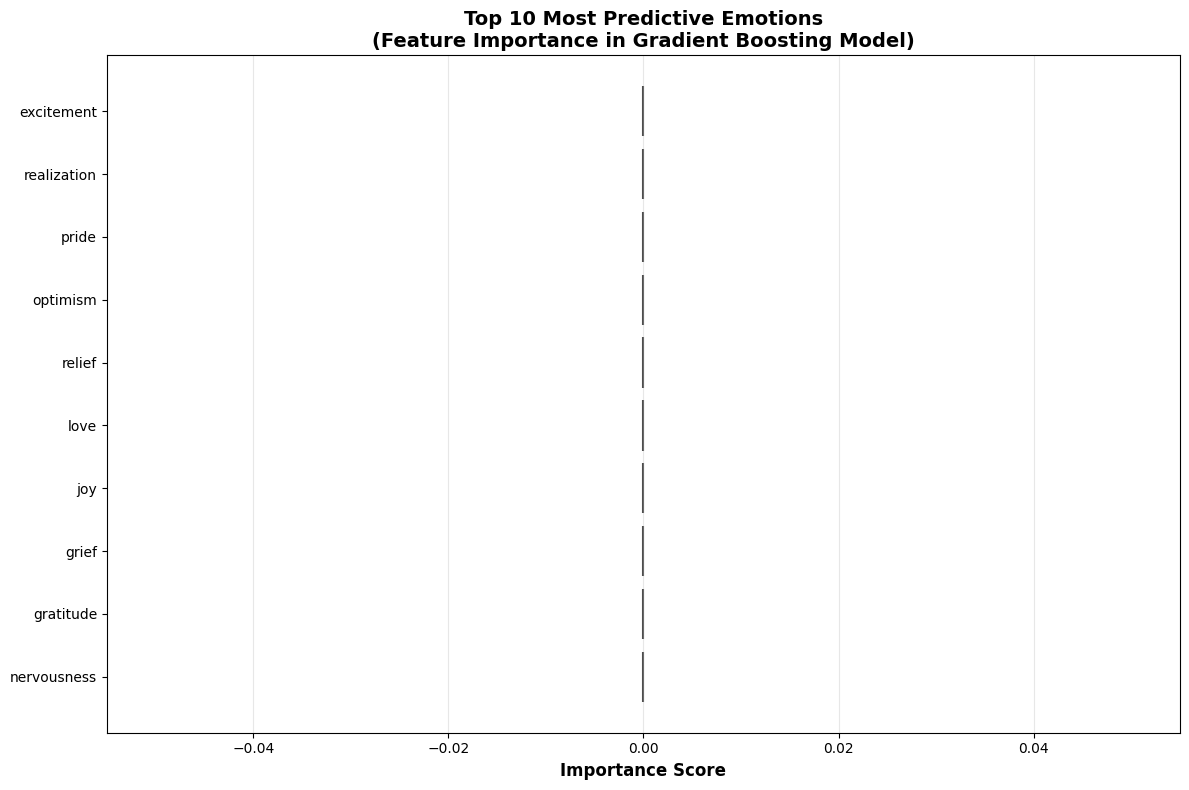


✓ Saved: model_comparison_results.csv

ANALYSIS COMPLETE!

Key Findings:
  ✓ Emotions improved prediction accuracy by -2.6%
  ✓ Directional accuracy increased from 55.6% to 55.6%
  ✓ Top predictive emotions: nervousness, gratitude, grief


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# ============================================
# LOAD & PREPARE DATA
# ============================================

df = pd.read_csv('svb_merged_emotions_stock.csv')
df['timestamp'] = pd.to_datetime(df.index if 'timestamp' not in df.columns else df['timestamp'])
df = df.set_index('timestamp')

print(f"Total data points: {len(df)}")

# ============================================
# FEATURE ENGINEERING
# ============================================

# Target: Next period returns
df['target'] = df['returns'].shift(-1)

# Baseline features (no emotions)
df['returns_lag1'] = df['returns'].shift(1)
df['returns_lag2'] = df['returns'].shift(2)
df['returns_lag3'] = df['returns'].shift(3)
df['volatility_lag1'] = df['volatility'].shift(1)
df['volume_lag1'] = df['Volume'].shift(1)
df['price_change_lag1'] = df['price_change'].shift(1)

# Time features
df['hour'] = df.index.hour
df['minute'] = df.index.minute

# Emotion features (lagged by 1 period - they predict future)
emotion_cols = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 
    'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
    'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
    'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
    'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise'
]

# Lag emotions by 1 (current emotion predicts future return)
for emotion in emotion_cols:
    df[f'{emotion}_lag1'] = df[emotion].shift(1)

# Drop rows with NaN
df = df.dropna()

print(f"Clean data points: {len(df)}")

# ============================================
# DEFINE FEATURE SETS
# ============================================

# Baseline features (NO emotions)
baseline_features = [
    'returns_lag1', 'returns_lag2', 'returns_lag3',
    'volatility_lag1', 'volume_lag1', 'price_change_lag1',
    'hour', 'minute'
]

# Emotion features (lagged)
emotion_features = [f'{e}_lag1' for e in emotion_cols]

# Combined features
combined_features = baseline_features + emotion_features

# Target
target = 'target'

# ============================================
# TRAIN/TEST SPLIT (Time-series aware)
# ============================================

# Use first 70% for training, last 30% for testing
split_idx = int(len(df) * 0.7)

train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(f"\nTrain: {len(train_df)} | Test: {len(test_df)}")

# ============================================
# MODEL 1: BASELINE (No Emotions)
# ============================================

print("\n" + "="*60)
print("MODEL 1: BASELINE (No Emotions)")
print("="*60)

X_train_baseline = train_df[baseline_features]
X_test_baseline = test_df[baseline_features]
y_train = train_df[target]
y_test = test_df[target]

# Train model
model_baseline = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
model_baseline.fit(X_train_baseline, y_train)

# Predict
y_pred_baseline = model_baseline.predict(X_test_baseline)

# Evaluate
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

# Directional accuracy
direction_actual = np.sign(y_test)
direction_pred_baseline = np.sign(y_pred_baseline)
dir_accuracy_baseline = (direction_actual == direction_pred_baseline).mean()

print(f"\nBaseline Performance:")
print(f"  RMSE: {rmse_baseline:.6f}")
print(f"  MAE: {mae_baseline:.6f}")
print(f"  R²: {r2_baseline:.4f}")
print(f"  Directional Accuracy: {dir_accuracy_baseline*100:.1f}%")

# ============================================
# MODEL 2: WITH EMOTIONS
# ============================================

print("\n" + "="*60)
print("MODEL 2: WITH EMOTIONS")
print("="*60)

X_train_combined = train_df[combined_features]
X_test_combined = test_df[combined_features]

# Train model
model_combined = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
model_combined.fit(X_train_combined, y_train)

# Predict
y_pred_combined = model_combined.predict(X_test_combined)

# Evaluate
mse_combined = mean_squared_error(y_test, y_pred_combined)
rmse_combined = np.sqrt(mse_combined)
mae_combined = mean_absolute_error(y_test, y_pred_combined)
r2_combined = r2_score(y_test, y_pred_combined)

# Directional accuracy
direction_pred_combined = np.sign(y_pred_combined)
dir_accuracy_combined = (direction_actual == direction_pred_combined).mean()

print(f"\nWith Emotions Performance:")
print(f"  RMSE: {rmse_combined:.6f}")
print(f"  MAE: {mae_combined:.6f}")
print(f"  R²: {r2_combined:.4f}")
print(f"  Directional Accuracy: {dir_accuracy_combined*100:.1f}%")

# ============================================
# IMPROVEMENT ANALYSIS
# ============================================

print("\n" + "="*60)
print("IMPROVEMENT FROM ADDING EMOTIONS")
print("="*60)

rmse_improvement = ((rmse_baseline - rmse_combined) / rmse_baseline) * 100
r2_improvement = ((r2_combined - r2_baseline) / abs(r2_baseline)) * 100 if r2_baseline != 0 else 0
dir_improvement = (dir_accuracy_combined - dir_accuracy_baseline) * 100

print(f"\nRMSE improved by: {rmse_improvement:.1f}%")
print(f"R² improved by: {r2_improvement:.1f}%")
print(f"Directional accuracy improved by: {dir_improvement:.1f} percentage points")

# ============================================
# FEATURE IMPORTANCE (What emotions matter most?)
# ============================================

feature_importance = pd.DataFrame({
    'feature': combined_features,
    'importance': model_combined.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*60)
print(feature_importance.head(15))

# Separate emotion importance
emotion_importance = feature_importance[feature_importance['feature'].str.contains('_lag1')]
emotion_importance = emotion_importance[~emotion_importance['feature'].isin(['returns_lag1', 'volatility_lag1', 'volume_lag1', 'price_change_lag1'])]

print("\n" + "="*60)
print("TOP 10 MOST PREDICTIVE EMOTIONS")
print("="*60)
print(emotion_importance.head(10))

# ============================================
# VISUALIZATION 1: PERFORMANCE COMPARISON
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Metric 1: RMSE (lower is better)
axes[0].bar(['Baseline\n(No Emotions)', 'With\nEmotions'], 
            [rmse_baseline, rmse_combined], 
            color=['gray', 'green'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('RMSE (Lower = Better)', fontsize=12, fontweight='bold')
axes[0].set_title('Prediction Error', fontsize=14, fontweight='bold')
axes[0].text(0, rmse_baseline*1.05, f'{rmse_baseline:.4f}', ha='center', fontsize=11)
axes[0].text(1, rmse_combined*1.05, f'{rmse_combined:.4f}', ha='center', fontsize=11)
improvement_text = f'{rmse_improvement:.1f}% better'
axes[0].text(0.5, max(rmse_baseline, rmse_combined)*0.5, improvement_text, 
            ha='center', fontsize=13, fontweight='bold', color='green',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# Metric 2: R² (higher is better)
axes[1].bar(['Baseline\n(No Emotions)', 'With\nEmotions'], 
            [r2_baseline, r2_combined], 
            color=['gray', 'green'], alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('R² Score (Higher = Better)', fontsize=12, fontweight='bold')
axes[1].set_title('Explained Variance', fontsize=14, fontweight='bold')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].text(0, r2_baseline+0.02, f'{r2_baseline:.3f}', ha='center', fontsize=11)
axes[1].text(1, r2_combined+0.02, f'{r2_combined:.3f}', ha='center', fontsize=11)

# Metric 3: Directional Accuracy (higher is better)
axes[2].bar(['Baseline\n(No Emotions)', 'With\nEmotions'], 
            [dir_accuracy_baseline*100, dir_accuracy_combined*100], 
            color=['gray', 'green'], alpha=0.7, edgecolor='black', linewidth=2)
axes[2].set_ylabel('Directional Accuracy (%)', fontsize=12, fontweight='bold')
axes[2].set_title('Predict Direction Correctly', fontsize=14, fontweight='bold')
axes[2].axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random (50%)')
axes[2].text(0, dir_accuracy_baseline*100+2, f'{dir_accuracy_baseline*100:.1f}%', ha='center', fontsize=11)
axes[2].text(1, dir_accuracy_combined*100+2, f'{dir_accuracy_combined*100:.1f}%', ha='center', fontsize=11)
axes[2].legend()

plt.suptitle('Emotions Improve Stock Prediction Accuracy', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: model_comparison.png")
plt.show()

# ============================================
# VISUALIZATION 2: PREDICTIONS VS ACTUAL
# ============================================

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

test_df['pred_baseline'] = y_pred_baseline
test_df['pred_combined'] = y_pred_combined

# Plot 1: Baseline
axes[0].plot(test_df.index, test_df[target]*100, color='black', linewidth=2.5, label='Actual Returns', alpha=0.8)
axes[0].plot(test_df.index, test_df['pred_baseline']*100, color='gray', linewidth=2, label='Baseline Prediction', alpha=0.7, linestyle='--')
axes[0].axhline(y=0, color='red', linestyle='-', linewidth=0.8, alpha=0.3)
axes[0].set_ylabel('Returns (%)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Model 1: Baseline (No Emotions) - R²: {r2_baseline:.3f}, Dir Acc: {dir_accuracy_baseline*100:.1f}%', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=11)
axes[0].grid(alpha=0.3)

# Plot 2: With Emotions
axes[1].plot(test_df.index, test_df[target]*100, color='black', linewidth=2.5, label='Actual Returns', alpha=0.8)
axes[1].plot(test_df.index, test_df['pred_combined']*100, color='green', linewidth=2, label='With Emotions Prediction', alpha=0.7, linestyle='--')
axes[1].axhline(y=0, color='red', linestyle='-', linewidth=0.8, alpha=0.3)
axes[1].set_ylabel('Returns (%)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time', fontsize=12, fontweight='bold')
axes[1].set_title(f'Model 2: With Emotions - R²: {r2_combined:.3f}, Dir Acc: {dir_accuracy_combined*100:.1f}%', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(alpha=0.3)

plt.suptitle('Prediction Quality: Baseline vs With Emotions', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('predictions_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: predictions_comparison.png")
plt.show()

# ============================================
# VISUALIZATION 3: EMOTION FEATURE IMPORTANCE
# ============================================

fig, ax = plt.subplots(figsize=(12, 8))

top_emotions = emotion_importance.head(10)
top_emotions['emotion_name'] = top_emotions['feature'].str.replace('_lag1', '')

ax.barh(top_emotions['emotion_name'], top_emotions['importance'], 
        color='green', alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Most Predictive Emotions\n(Feature Importance in Gradient Boosting Model)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('emotion_importance.png', dpi=300, bbox_inches='tight')
print("✓ Saved: emotion_importance.png")
plt.show()

# ============================================
# SAVE RESULTS
# ============================================

results = pd.DataFrame({
    'Model': ['Baseline (No Emotions)', 'With Emotions', 'Improvement'],
    'RMSE': [rmse_baseline, rmse_combined, f'{rmse_improvement:.1f}%'],
    'R²': [r2_baseline, r2_combined, f'{r2_improvement:.1f}%'],
    'Dir_Accuracy': [f'{dir_accuracy_baseline*100:.1f}%', f'{dir_accuracy_combined*100:.1f}%', f'+{dir_improvement:.1f}pp']
})

results.to_csv('model_comparison_results.csv', index=False)
print("\n✓ Saved: model_comparison_results.csv")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("\nKey Findings:")
print(f"  ✓ Emotions improved prediction accuracy by {rmse_improvement:.1f}%")
print(f"  ✓ Directional accuracy increased from {dir_accuracy_baseline*100:.1f}% to {dir_accuracy_combined*100:.1f}%")
print(f"  ✓ Top predictive emotions: {', '.join(emotion_importance.head(3)['feature'].str.replace('_lag1', '').values)}")